<a href="https://colab.research.google.com/github/Mayakshanesht/3d-deep-learning/blob/main/PointNet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Do this if you don't have Open3D
!pip install open3d==0.12.0 # Version 12
!pip install progressbar

     |████████████████████████████████| 188.4 MB 32 kB/s 
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=29565009c319363d4c9d6be11f2357e8000ebc4aaa8457c3bf91d8cf63668bae
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [ ]:
# Usual Imports
from __future__ import print_function
import os
import random
from random import randrange
from IPython.display import clear_output
from PIL import Image
import os.path
import errno
import json
import codecs
import numpy as np
import progressbar
import sys
import matplotlib.pyplot as plt

# Open3D Imports
import open3d as o3
print(o3.__version__)
from open3d import JVisualizer # Useful for Jupyter Notebook Visualization

# PyTorch Imports
import torch #Version 1.7.0 is the one used in the course
print(torch.__version__)
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

0.12.0
1.9.0+cu102


In [ ]:
#Run this only if you don't already have the Dataset
!wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
!unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
!rm shapenetcore_partanno_segmentation_benchmark_v0.zip

Streaming output truncated to the last 5000 lines.
  inflating: shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/e1225308d6c26c862b600da24e0965.png  
  inflating: shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/46ae88cad17edca7ae7c0d0e12bd33da.png  
  inflating: shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/1ea7a36e4f353416fe1f6e05091d5d9.png  
  inflating: shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/e94ad5f8e53a255a8fc2d09ac4aa4e78.png  
  inflating: shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/8b61ba80d9e487deca8607f540cc62ba.png  
  inflating: shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/3cbc83ba49edeccebc0909d98a1ff2b4.png  
  inflating: shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/c5d0dd7a7b44b079a76ffc04f04676cb.png  
  inflating: shapenetcore_partanno_segmentation_benchmark_v0/02691156/seg_img/75db11c354c6342aad01ec966c80ac91.png  
  inflating: sha

In [ ]:
# Avoid an SSL Error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# General parameters
NUM_POINTS = 10000
DATA_FOLDER = 'shapenetcore_partanno_segmentation_benchmark_v0'

In [ ]:
class PartDataset(torch.utils.data.Dataset):
    """
    This preprocesses the dataset.
    """
    def __init__(self, root, npoints = 2500, classification = False, class_choice = None, train = True, image=False):
        '''
        Assign the parameters: number of points, root folder, category file, image, classification.
        '''
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}
        self.image = image
        self.classification = classification
        '''
        Open the Category File and Map Folders to Categories
        '''
        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        #print(self.cat)
        
        '''
        Select categories from the dataset. 
        ex: Call in parameters "class_choice=["Airplane"].
        '''
        if not class_choice is  None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}
        
        '''
        For every item in a specific category, assign the point, segmentation, and image.
        Basically, read the dataset and store the labels.
        '''
        self.meta = {}        
        for item in self.cat:
            #print('category', item)
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item], 'points')
            dir_seg = os.path.join(self.root, self.cat[item], 'points_label')
            dir_seg_img = os.path.join(self.root, self.cat[item], 'seg_img')
            #print(dir_point, dir_seg)
            
            fns = sorted(os.listdir(dir_point))
            if train:
                fns = fns[:int(len(fns) * 0.9)]
            else:
                fns = fns[int(len(fns) * 0.9):]

            #print(os.path.basename(fns))
            for fn in fns: # FOR EVERY POINT CLOUD FILE
                token = (os.path.splitext(os.path.basename(fn))[0])
                self.meta[item].append((os.path.join(dir_point, token + '.pts'), os.path.join(dir_seg, token + '.seg'), os.path.join(dir_seg_img, token+'.png')))

        '''
        Create a Variable where you have (item, points, segmentation points, segmentation image)
        '''
        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn[0], fn[1], fn[2]))

        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        #print(self.classes)
        
        self.num_seg_classes = 0
        if not self.classification: # Take the Segmentation Labels
            for i in range(len(self.datapath)//50):
                l = len(np.unique(np.loadtxt(self.datapath[i][-2]).astype(np.uint8)))
                if l > self.num_seg_classes:
                    self.num_seg_classes = l
        #print(self.num_seg_classes)

    def __getitem__(self, index):
        '''
        This will be used to pick a specific element from the dataset.
        self.datapath is the dataset.
        Each element is under format "class, points, segmentation labels, segmentation image"
        '''
        # Get one Element
        fn = self.datapath[index]
        #print(fn)
        
        # get its Class
        cls = self.classes[fn[0]]
        #print(cls)
        
        # Read the Point Cloud
        point_set = np.asarray(o3.io.read_point_cloud(fn[1], format='xyz').points,dtype=np.float32)
        
        # Read the Segmentation Data
        seg = np.loadtxt(fn[2]).astype(np.int64)

        #print(point_set.shape, seg.shape)
        
        # Read the Segmentation Image
        image = Image.open(fn[3])

        choice = np.random.choice(len(seg), self.npoints, replace=True)
        
        #resample
        point_set = point_set[choice, :]        
        seg = seg[choice]
        point_set = torch.from_numpy(point_set)
        seg = torch.from_numpy(seg)
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))
        
        if self.classification:
            if self.image:
                return point_set, cls, image
            else:
                return point_set, cls

        else:
            if self.image:
                return point_set, seg, image
            else:
                return point_set, seg

    def __len__(self):
        return len(self.datapath)

In [ ]:
a=PartDataset(DATA_FOLDER,class_choice=None)

shapenetcore_partanno_segmentation_benchmark_v0/02691156/points shapenetcore_partanno_segmentation_benchmark_v0/02691156/points_label
shapenetcore_partanno_segmentation_benchmark_v0/02773838/points shapenetcore_partanno_segmentation_benchmark_v0/02773838/points_label
shapenetcore_partanno_segmentation_benchmark_v0/02954340/points shapenetcore_partanno_segmentation_benchmark_v0/02954340/points_label
shapenetcore_partanno_segmentation_benchmark_v0/02958343/points shapenetcore_partanno_segmentation_benchmark_v0/02958343/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03001627/points shapenetcore_partanno_segmentation_benchmark_v0/03001627/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03261776/points shapenetcore_partanno_segmentation_benchmark_v0/03261776/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03467517/points shapenetcore_partanno_segmentation_benchmark_v0/03467517/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03624134/point

In [ ]:
# Problem ontology
classes_dict = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

In [ ]:
# Simple point cloud coloring mapping
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

Number of objects 15990
----------
Point Cloud Caracteristics:
torch.Size([2500, 3]) torch.FloatTensor torch.Size([2500]) torch.LongTensor
----------
Point Cloud
tensor([[-0.0381, -0.0387,  0.0681],
        [ 0.2396, -0.0419,  0.0257],
        [ 0.2522, -0.0062, -0.0231],
        ...,
        [-0.0440, -0.0407,  0.0386],
        [ 0.3311, -0.0104, -0.0205],
        [-0.1655, -0.0103, -0.0636]])
----------
Label on Part Segmentation
tensor([2, 1, 1,  ..., 2, 1, 4])
----------
Label on Classification
Airplane


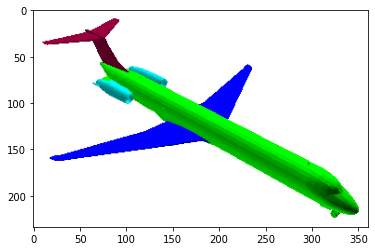

In [ ]:
# Load the ShapeNet Dataset
# Default parameters for PartDataset: npoints = 2500, classification = False, class_choice = None, train = True, image=False

d = PartDataset(root = DATA_FOLDER, image=True)
print("Number of objects",len(d))
print('----------')

idx = random.randint(0,len(d))
ps, seg, img = d[idx]

print("Point Cloud Caracteristics:")
print(ps.size(), ps.type(), seg.size(),seg.type())
print('----------')
print("Point Cloud")
print(ps)
print('----------')
print("Label on Part Segmentation")
print(seg)
print('----------')
d = PartDataset(root = DATA_FOLDER, classification = True, image=False)
ps2, cls= d[idx]
print("Label on Classification")
classes_dict_list = list(classes_dict)
print(classes_dict_list[cls.item()])
plt.imshow(np.asarray(img))

In [ ]:
class STN3d(nn.Module):
    """
    T-Net Model. 
    STN stands for Spatial Transformer Network.
    """
    def __init__(self, num_points = 2500):
        super(STN3d, self).__init__()
        self.num_points = num_points
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.mp1(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

sim_data = Variable(torch.rand(32,3,2500))
trans = STN3d()
out = trans(sim_data)
print('stn', out.size())

stn torch.Size([32, 3, 3])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
class PointNetfeat(nn.Module):
    """
    This is the T-Net for Feature Transform.
    There is also MLP part 64,128,1024.
    """
    def __init__(self, num_points = 2500, global_feat = True):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d(num_points = num_points)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.num_points = num_points
        self.global_feat = global_feat
        
    def forward(self, x):
        batchsize = x.size()[0]
        trans = self.stn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans)
        x = x.transpose(2,1)
        x = F.relu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = self.mp1(x)
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, self.num_points)
            return torch.cat([x, pointfeat], 1), trans

In [ ]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

global feat torch.Size([32, 1024])


In [ ]:
class PointNetCls(nn.Module):
    """
    Network for Classification: 512, 256, K.
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetCls, self).__init__()
        self.num_points = num_points
        self.feat = PointNetfeat(num_points, global_feat=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
    def forward(self, x):
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1), trans

In [ ]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

pointfeat = PointNetfeat(global_feat=False)
out, _ = pointfeat(sim_data)
print('point feat', out.size())

cls = PointNetCls(k = 5)
out, _ = cls(sim_data)
print('class', out.size())

global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])
class torch.Size([32, 5])


In [ ]:
class PointNetDenseCls(nn.Module):
    """
    Network for Segmentation
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetDenseCls, self).__init__()
        self.num_points = num_points
        self.k = k
        self.feat = PointNetfeat(num_points, global_feat=False)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, self.num_points, self.k)
        return x, trans

In [ ]:
seg = PointNetDenseCls(k = 3)
print(seg)
out, _ = seg(sim_data)
print('seg', out.size())

PointNetDenseCls(
  (feat): PointNetfeat(
    (stn): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (mp1): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True

In [ ]:
batchSize = 32 #32
num_points = 2500 #2500
workers = 4 #4
nepoch = 25 #25
outf="cls" #'cls'

In [37]:
# DATASET & DATA LOADER
dataset = PartDataset(root = DATA_FOLDER, classification = True, npoints = num_points)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=workers)

test_dataset = PartDataset(root = DATA_FOLDER, classification = True, train = False, npoints = num_points)
testdataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,shuffle=True, num_workers=workers)

blue = lambda x:'\033[94m' + x + '\033[0m'

# CALL THE MODEL
num_classes = len(classes_dict.items())
classifier = PointNetCls(k = num_classes, num_points = num_points)
#classifier.load_state_dict(torch.load(""))

# DEFINE OPTIMIZERS
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
if torch.cuda.is_available():
    classifier.cuda()

num_batch = len(dataset)/batchSize

# TRAIN ON EPOCHS
for epoch in range(nepoch):
    for i, data in enumerate(dataloader, 0):
        """
        Get Points & Classification Label
        """
        points, target = data
        points, target= Variable(points), Variable(target[:,0])
        points = points.transpose(2,1)
        if torch.cuda.is_available():
            points, target = points.cuda(), target.cuda()
        
        optimizer.zero_grad()
        classifier = classifier.train()
        pred, _ = classifier(points)
        loss = F.nll_loss(pred, target)
        loss.backward()
        optimizer.step()
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        print('[%d: %d/%d] train loss: %f accuracy: %f' %(epoch, i, num_batch, loss.item(),correct.item() / float(batchSize)))

        if i % 10 == 0:
            j, data = next(enumerate(testdataloader, 0))
            points, target = data
            points, target = Variable(points), Variable(target[:,0])
            points = points.transpose(2,1)
            if torch.cuda.is_available():
                points, target = points.cuda(), target.cuda()
            classifier = classifier.eval()
            pred, _ = classifier(points)
            loss = F.nll_loss(pred, target)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            print('[%d: %d/%d] %s loss: %f accuracy: %f' %(epoch, i, num_batch, blue('test'), loss.item(), correct.item()/float(batchSize)))



shapenetcore_partanno_segmentation_benchmark_v0/02691156/points shapenetcore_partanno_segmentation_benchmark_v0/02691156/points_label
shapenetcore_partanno_segmentation_benchmark_v0/02773838/points shapenetcore_partanno_segmentation_benchmark_v0/02773838/points_label
shapenetcore_partanno_segmentation_benchmark_v0/02954340/points shapenetcore_partanno_segmentation_benchmark_v0/02954340/points_label
shapenetcore_partanno_segmentation_benchmark_v0/02958343/points shapenetcore_partanno_segmentation_benchmark_v0/02958343/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03001627/points shapenetcore_partanno_segmentation_benchmark_v0/03001627/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03261776/points shapenetcore_partanno_segmentation_benchmark_v0/03261776/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03467517/points shapenetcore_partanno_segmentation_benchmark_v0/03467517/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03624134/point

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0: 0/499] train loss: 2.938644 accuracy: 0.000000
[0: 0/499] test loss: 2.755652 accuracy: 0.031250
[0: 1/499] train loss: 2.618561 accuracy: 0.093750
[0: 2/499] train loss: 2.157503 accuracy: 0.562500
[0: 3/499] train loss: 1.792897 accuracy: 0.593750
[0: 4/499] train loss: 1.234075 accuracy: 0.781250
[0: 5/499] train loss: 1.627008 accuracy: 0.593750
[0: 6/499] train loss: 1.013324 accuracy: 0.781250
[0: 7/499] train loss: 0.692124 accuracy: 0.812500
[0: 8/499] train loss: 0.711570 accuracy: 0.812500
[0: 9/499] train loss: 0.890969 accuracy: 0.750000
[0: 10/499] train loss: 0.325400 accuracy: 0.937500
[0: 10/499] test loss: 2.486339 accuracy: 0.187500
[0: 11/499] train loss: 0.358616 accuracy: 0.906250
[0: 12/499] train loss: 1.030956 accuracy: 0.656250
[0: 13/499] train loss: 0.865075 accuracy: 0.781250
[0: 14/499] train loss: 0.539561 accuracy: 0.812500
[0: 15/499] train loss: 0.617702 accuracy: 0.843750
[0: 16/499] train loss: 0.762122 accuracy: 0.750000
[0: 17/499] train loss: 0

KeyboardInterrupt: ignored

In [38]:
torch.save(classifier.state_dict(), 'cls_model_3.pth')

In [40]:
NUM_POINTS = 10000
MODEL_PATH = 'cls_model_3.pth'

# Create the classification network from pre-trained model
classifier = PointNetCls(k=num_classes, num_points=NUM_POINTS)
if torch.cuda.is_available():
    classifier.cuda()
    classifier.load_state_dict(torch.load(MODEL_PATH))
else:
    classifier.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
classifier.eval()

PointNetCls(
  (feat): PointNetfeat(
    (stn): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (mp1): MaxPool1d(kernel_size=10000, stride=10000, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, t

shapenetcore_partanno_segmentation_benchmark_v0/02691156/points shapenetcore_partanno_segmentation_benchmark_v0/02691156/points_label
shapenetcore_partanno_segmentation_benchmark_v0/02773838/points shapenetcore_partanno_segmentation_benchmark_v0/02773838/points_label
shapenetcore_partanno_segmentation_benchmark_v0/02954340/points shapenetcore_partanno_segmentation_benchmark_v0/02954340/points_label
shapenetcore_partanno_segmentation_benchmark_v0/02958343/points shapenetcore_partanno_segmentation_benchmark_v0/02958343/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03001627/points shapenetcore_partanno_segmentation_benchmark_v0/03001627/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03261776/points shapenetcore_partanno_segmentation_benchmark_v0/03261776/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03467517/points shapenetcore_partanno_segmentation_benchmark_v0/03467517/points_label
shapenetcore_partanno_segmentation_benchmark_v0/03624134/point

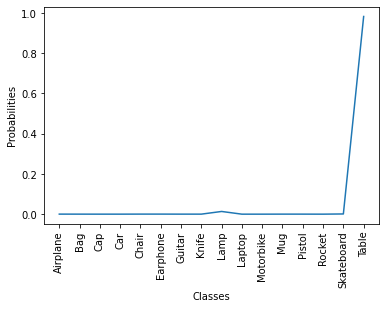

Your object is a [Table] with probability 0.983. Press enter to continue!
[Sample 468 / 1785]


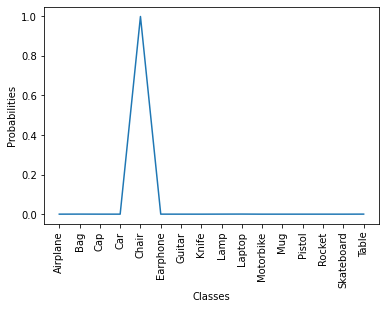

Your object is a [Chair] with probability 0.998. Press enter to continue!


In [41]:
# Three.js based visualizer
#visualizer = JVisualizer()

test_dataset_seg = PartDataset(root=DATA_FOLDER, train=False, classification=True, npoints=NUM_POINTS)

# Basic inference and visualization loop
MAX_SAMPLES = 2
for samples in range(MAX_SAMPLES):
    random_index = randrange(len(test_dataset_seg))
    print('[Sample {} / {}]'.format(random_index, len(test_dataset_seg)))
    
    # clean visualization
    #visualizer.clear()
    #clear_output()

    # get next sample
    point_set, seg = test_dataset_seg.__getitem__(random_index)

    # create cloud for visualization
    #cloud = o3.geometry.PointCloud()
    #cloud.points = o3.utility.Vector3dVector(point_set)
    #cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

    # perform inference in GPU
    points = Variable(point_set.unsqueeze(0))
    points = points.transpose(2, 1)
    if torch.cuda.is_available():
        points = points.cuda()
    pred_logsoft, _ = classifier(points)

    # move data back to cpu for visualization
    pred_logsoft_cpu = pred_logsoft.data.cpu().numpy().squeeze()
    pred_soft_cpu = np.exp(pred_logsoft_cpu)
    pred_class = np.argmax(pred_soft_cpu)

    # let's visualize the input sample
    #visualizer.add_geometry(cloud)
    #visualizer.show()
    
    # Visualize probabilities
    plt.xticks(list(classes_dict.values()), list(classes_dict.keys()),rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.plot(list(classes_dict.values()), pred_soft_cpu)
    plt.show()

    input('Your object is a [{}] with probability {:0.3}. Press enter to continue!'
          .format(list(classes_dict.keys())[pred_class], pred_soft_cpu[pred_class]))